In [ ]:
from tracking_plot import plot_ratemap,plot_path
from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import normalize
from spatial_maps.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from spatial_maps import maps
from scipy.ndimage import gaussian_filter1d
from spatial_maps.data import pos2speed

In [11]:
filepath = r"S:\Sachuriga/nwb/65588_2024-03-08_14-47-56_A_phy_k_manual.nwb"
data = nap.load_file(filepath)
data

65588_2024-03-08_14-47-56_A_phy_k_manual
┍━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━┑
│ Keys             │ Type     │
┝━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━┥
│ units            │ TsGroup  │
│ lfp_raw          │ TsdFrame │
│ lfp_car          │ TsdFrame │
│ XY               │ TsdFrame │
│ XY_snout         │ TsdFrame │
│ MD               │ TsdFrame │
│ HD               │ Tsd      │
│ BD               │ Tsd      │
│ ElectricalSeries │ TsdFrame │
┕━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━┙

In [ ]:
a = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1\65588\65588_2024-03-14_14-26-31_A\Record Node 101\experiment1\recording1\continuous\Acquisition_Board-100.Rhythm Data/sample_numbers.npy")
a

b = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1\65588\65588_2024-03-14_14-26-31_A\Record Node 101\experiment1\recording1\continuous\Acquisition_Board-100.Rhythm Data/timestamps.npy")
print(b)


c = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1\65588\65588_2024-03-14_14-26-31_A\Record Node 101\experiment1\recording1\events\Acquisition_Board-100.Rhythm Data\TTL/timestamps.npy")
print(np.diff(c))


57930

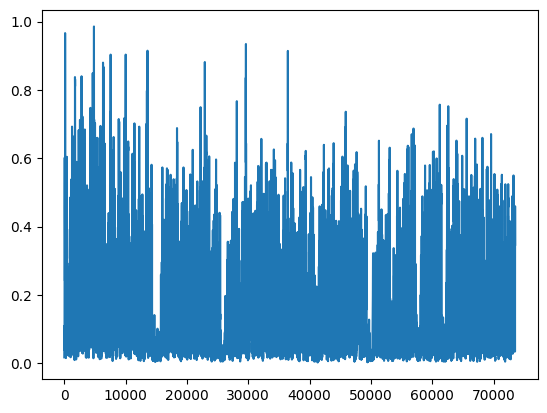

In [ ]:
from scipy.ndimage import gaussian_filter

scaler = MinMaxScaler()
# Fit and transform the data
pos = data['XY_snout']
t = data['XY_snout'].as_dataframe().index
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(np.array(pos['x']).reshape(-1, 1)).flatten()
y = scaler.fit_transform(np.array(pos['y']).reshape(-1, 1)).flatten()


def pos2speed(t,x,y,filter_speed=True):
    delta_X = np.diff(x)
    delta_Y = np.diff(y)
    sampling_intervals = np.diff(t)
    average_sampling_interval = np.median(sampling_intervals)
    interval =round(average_sampling_interval, 4)
    samplingrate = 1/interval
    n = samplingrate * 0.4
    truncate = 4.0  # 默认值
    # 计算 sigma
    sigma = (n - 1) / (2 * truncate)

    # Calculate distances between points
    delta_S = np.sqrt(delta_X**2 + delta_Y**2)
    speeds = delta_S*samplingrate

    # Compute instantaneous speeds
    smoothed_speed = gaussian_filter1d(speeds, sigma=sigma)
    plt.plot(smoothed_speed)
    mask = (smoothed_speed>=0.05)

    if filter_speed==True:
        return mask, smoothed_speed
    else:
        return smoothed_speed

mask,speed = pos2speed(t,x,y,filter_speed=True)


xx=x[1:]
yy=y[1:]
tt=t[1:]
ttt=tt
x = xx[mask]
y= yy[mask]
t = tt[mask]
len(x)

2863
here
[1.0, 1.0]
bins zie[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


<Axes: title={'center': '11.26 Hz'}>

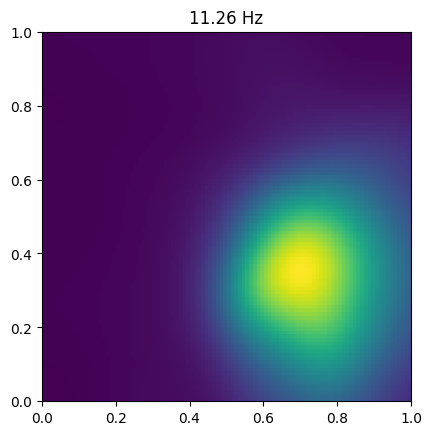

<Figure size 600x600 with 0 Axes>

In [4]:
units = data['units']
spikes_time = np.array(units[11].as_series().index)
print(len(spikes_time))
t_ = np.append(tt, tt[-1] + np.median(np.diff(tt)))
spikes_in_bin, _ = np.histogram(spikes_time, t_)
spk = spikes_in_bin[mask]
plot_ratemap(x,y,t,spikes_time,box_size=[1.0, 1.0], bin_size=0.01,smoothing=0.1)

In [5]:
import spatial_maps.maps as mapp
maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.01)
rate_map = maps.rate_map(x, y, t, spikes_time)
fields = separate_fields_by_laplace(rate_map, minimum_field_area=9)

fiesld_afremoval = remove_fields_by_area(fields, minimum_field_area=9)
bc = calculate_field_centers(rate_map, fiesld_afremoval, center_method='center_of_mass')
print(bc)
x_c = bc[1][0]
y_c = bc[1][1]

print(bc)
print(y_c)
print(fiesld_afremoval)
f = which_field(x,y,fiesld_afremoval,[1.0,1.0])
in_field = np.where(f==2)[0]
en,ex = compute_crossings(in_field)

xf = x[in_field]
yf = y[in_field]
tf = t[in_field]#
spk = spk[in_field]

#r, theta, pdcd, pdmd = map_pass_to_unit_circle(x, y, t, x_c/20, 1-(y_c/20), field=fields, box_size=[1.0,1.0])
r, theta, pdcd, pdmd = map_pass_to_unit_circle(xf, yf, tf, x_c/100, y_c/100, field=fiesld_afremoval, box_size=[1.0, 1.0])
print(fiesld_afremoval)

[1.0, 1.0]
bins zie[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[        nan         nan]
 [70.77987677 67.32502745]]
[[        nan         nan]
 [70.77987677 67.32502745]]
67.32502745350277
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\scipy\ndimage\_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [6]:
indices = np.zeros(len(x))
indices[in_field]=1

en,ex = compute_crossings(indices)
print(en)
print(ex) 

[  795   802  2017  2125  2466  2648  2798  2800  2803  2912  3363  3960
  4310  4410  4614  4705  4965  5359  5402  5954  6045  6527  7109  7187
  7668  8718  8773  9253  9352  9691  9780 10435 10557 10775 10938 11401
 11804 12155 13441 13751 14793 15092 15492 15568 15842 15963 16862 16864
 17349 18633 18682 18987 19334 19422 19692 19809 20370 20859 21369 21729
 22021 22915 23164 23805 23837 24054 24999 25086 26115 26224 26689 26814
 27124 27168 27505 27847 28370 28730 28864 28888 28987 28994 29344 29368
 29914 30726 30877 30880 31036 31348 31371 31426 31510 32159 33318 33330
 33370 33566 33732 33938 34016 34022 34471 35727 37470 37972 38298 38398
 39008 39200 39263 39693 39770 40060 40512 40701 41016 41866 42246 42541
 42549 43099 43160 43456 43661 43791 44305 44754 44830 44859 45052 45365
 45370 46155 46743 46913 47004 47050 47328 47357 47678 47688 47980 48494
 48725 49030 49360 49665 50181 50345 52043 52229 52649 52983 53568 53771
 54077 54207 54246 54595 54934 55329]
[  799   810 

In [ ]:


en,ex = compute_crossings(in_field)
print(in_field)
print(ex)

In [ ]:
slide_s = 13
slide_stop =40
plot_path(xf[slide_s:slide_stop],yf[slide_s:slide_stop],tf[slide_s:slide_stop],box_size=1,spike_times = spikes_time)
plt.figure()
plt.bar(tf[slide_s:slide_stop],xf[slide_s:slide_stop])

xr = xf[slide_s:slide_stop]
yr = yf[slide_s:slide_stop]
tr = tf[slide_s:slide_stop]

r, theta, pdcd, pdmd = map_pass_to_unit_circle(xr, yr, tr, x_c/100, y_c/100, field=fiesld_afremoval, box_size=[1.0, 1.0])

plt.figure()
plt.plot(tr,pdcd)

In [ ]:
plt.scatter(tf,xf)

In [ ]:
plt.scatter(yf,xf,c = spk, cmap='hot',s=6)
plt.xlim(0, 1)  # Set x-axis limits
plt.ylim(0, 1)
plt.show()

plt.plot(yf,xf)
plt.xlim(0, 1)  # Set x-axis limits
plt.ylim(0, 1)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mask = (r >-1) & (r < 1)
# x_filtered = x[mask]
# y_filtered = y[mask]
r_filtered = r[mask]
theta_filtered = theta[mask]
#co = spk[mask]


xr=xf[mask]
yr=yf[mask]

xx=[]
yy=[]

x1 = []
y1 = []

# Convert to Cartesian coordinates
for i in range(len(r_filtered)-1):
    xx.append(r_filtered[i] * np.cos(theta_filtered[i]))
    yy.append(r_filtered[i] * np.sin(theta_filtered[i]))
    x1.append(xr[i])
    y1.append(yr[i])

# Plot the circle
plt.figure(figsize=(5,5))
plt.scatter(xx, yy,cmap='hot', alpha=0.7,s=12)
#plt.colorbar(label='Intensity')
plt.title('Unit Circle')
#plt.xlabel('x')
#plt.ylabel('y')
plt.axis('equal')  # Ensures the x and y axes are scaled equally
plt.grid(True)
#plot_ratemap(x,y,t,spikes_time[1:],box_size=[1.0, 1.0], bin_size=0.05)
len(yy)

In [ ]:
plt.bar(r)

In [ ]:
mask = (r > -1) & (r < 1)

# Use the mask to filter x, y, and pdcd
x_filtered = x[mask]
y_filtered = y[mask]
pdcd_filtered = r[mask]
theta_filtered = theta[mask]


# Now plot using the filtered data
plt.scatter(x_filtered, y_filtered, c=pdcd_filtered, cmap='hot', alpha=0.7)
plt.colorbar(label='Intensity')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

In [ ]:
def map_pass_to_unit_circle(x, y, t, x_c, y_c, field=None, box_size=None, dist_func=None):
    """Uses three vectors {v,p,q} to map the passes to the unit circle. v
    is the average velocity vector of the pass, p is the vector from the
    position (x,y) to the center of the field and q is the vector from the
    center to the edge through (x,y). See [1].

    Parameters:
    -----------
        :x, y, t: np arrays
            should contain x,y and t data in numpy arrays
        :x_c , y_c: floats
            bump center
        :field: np 2d array (optional)
            bins indicating location of field.
        :dist_func: function (optional)
            dist_func(angle) = distance to bump edge from center
            default is distance_to_edge_function with linear interpolation
        :return_vecs(optional): bool, default False

    See also:
    ---------
    distance_to_edge_function

    Returns:
    --------
        r : array of distance to origin on unit circle
        theta : array of angles to axis defined by mean velocity vector
        pdcd : array of distance to peak projected onto the current direction
        pdmd : array of distance to peak projected onto the mean direction

    References:
    -----------
        [1]: A. Jeewajee et. al., Theta phase precession of grid and
        placecell firing in open environment
    """
    if dist_func is None:
        assert field is not None and box_size is not None, (
            'either provide "dist_func" or "field" and "box_size"')
        dist_func= distance_to_edge_function(
            x_c, y_c, field, box_size, interpolation='linear')
    pos = np.array((x, y))

    # vector from pos to center p
    p_vec = ((x_c, y_c) - pos.T).T

    # angle between x-axis and negative vector p
    angle = (np.arctan2(p_vec[1], p_vec[0]) + np.pi) % (2 * np.pi)
    # distance from center to edge at each angle
    q = dist_func(angle)
    # distance from center to pos
    p = np.linalg.norm(p_vec, axis=0)
    # r-coordinate on unit circle
    r = p / q

    dpos = np.gradient(pos, axis=1)
    dt = np.gradient(t)
    velocity = np.divide(dpos, dt)

    # mean velocity vector v
    mean_velocity = np.average(velocity, axis=1)
    # angle on unit circle, run is rotated such that mean velocity vector
    # is toward positive x
    theta = (angle - np.arctan2(mean_velocity[1], mean_velocity[0])) % (2 * np.pi)

    w_pdcd = (angle - np.arctan2(velocity[1], velocity[0]))
    pdcd = r * np.cos(w_pdcd)

    w_pdmd = (angle - np.arctan2(mean_velocity[1], mean_velocity[0]))
    pdmd = r * np.cos(w_pdmd)
    return r, theta, pdcd, pdmd


In [ ]:
min(pdcd)